## Two Towers Recommender in Tensorflow/Keras - Training and Deployment

This notebook implements the Two Towers Recommender in a recruiting solution.

Google has two products that help operationalize recommenders. One is Tensorflow Recommenders, that are built on Keras and are some are used for retrieval and ranking of candidates, like the Two Towers algorithm. The other is the Matching Engine, that compares embeddings and looks for Top K similarities. The Matching Engine compares the embeddings of a given query (candidate competences) with the embeddings of an index of vacancies to provide the TOP 10 nearest neighbors.


<div align='center'>
   <img src="https://1.bp.blogspot.com/-Rsymb9XvPOE/Xx8rfRnmTHI/AAAAAAAAGRQ/U2n_bBNXS4IBstYrx2IalrFXufLUvmn2gCLcBGAsYHQ/s640/ScaNN%2Btom%2Bexport.gif">
</div>

Recommender systems are often composed of three stages:
- The <b>retrieval</b> stage is responsible for selecting an initial set of hundreds of candidates from all possible candidates.
- The <b>ranking</b> stage takes the outputs of the retrieval model and fine-tunes them to select the best possible handful of recommendations, what I called TOP K.
- The <b>filtering</b> stage filters the TOP K results so that you only get relevant results.

<div align='center'>
   <img src="https://miro.medium.com/v2/resize:fit:786/format:webp/1*od4VCyVmh4VMZgcxnyiPCA.png">
    </p>
    A two-stage recommender system that serves users highly personalized content within the strict latency. It consists
of an efficient candidate generation model in the first stage and a more powerful ranking model in the second stage.
    Source: https://dl.acm.org/doi/abs/10.1145/3366423.3380130
</div>
</p>
More comprehensive explanations as well as production level deployments are found at the following articles on Google Blog and my Medium:
</p>
<b>Off-policy Learning in Two-stage Recommender Systems</b> https://dl.acm.org/doi/abs/10.1145/3366423.3380130

<b>Announcing ScaNN: Efficient Vector Similarity Search</b> https://blog.research.google/2020/07/announcing-scann-efficient-vector.html?m=1

<b>Train and Deploy Google Cloud’s Two Towers Recommender</b> https://medium.com/p/3ae5c29891af

<b>Two Towers Model: A Custom Pipeline in Vertex AI Using Kubeflow</b> https://medium.com/p/3451cd1ca8d5

## Dependencies

The Two Towers model has two sub-models: a query model and a candidate model as you will see ahead. So, let’s put it in practice with Python. First, install necessary libraries. If you are using Vertex AI, in Workbench choose Tensorflow 2.8 without GPU image, zone us-central1.

As SCANN installation is quite critical, you may want to run a factory reset in Kaggle notebook before each time you open it to make it work properly.


In [1]:
! pip install tensorflow-text --quiet
! pip install tensorflow-recommenders --quiet
! pip install scann --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
chex 0.1.82 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.11.2 which is incompatible.
tensorflow-decision-forests 1.4.0 requires tensorflow~=2.12.0, but you have tensorflow 2.13.1 which is incompatible.
tensorflow-text 2.12.1 requires tensorflow<2.13,>=2.12.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.13.1 which is incompatible.
ydata-profiling 4.3.1 requires scipy<1.11,>=1.4.1, but you have scipy 1.11.2 which is incompatible.


Now, let's import necessary libraries:

In [2]:
import pprint
import tempfile
from typing import Dict, Text
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs 
import os
import unidecode
from nltk import word_tokenize
import re
import pandas as pd

Here I'm using a custom dataset I obtained manually from websites like Indeed and LinkedIn, that contains the vacancy URL, name of the vacancy, name of the company, size of the company, language, country, state, city, decription of the vacancy, benefits and desired competences, separated in columns. This dataset is now public in Kaggle.

## Dataset

In [3]:
df=pd.read_csv('/kaggle/input/recruiting-dataset-in-spanish/Recruiting_Dataset_spanish.csv',sep=';',header=0)
df.iloc[:10,0:12]

,Site,nome da vaga,nome da empresa,tamanho da empresa,linguagem,pais,estado,cidade da vaga,descrição,beneficios,vaga de diversidade,data da postagem
0,https://co.indeed.com/viewjob?jk=4756032fee4cc...,cajero auxiliar cartagena,eficacia s.a.,más de 10 000,espanhol,Colômbia,bolívar,Cartagena,buscamos cajeros con excelente presentacion pe...,"prestaciones de ley + recargos dominicales, fe...",0,Publicado 12/08
1,https://co.indeed.com/viewjob?jk=7c64b755eff2b...,Asesora Comercial,Arquitectura & Concreto,0,espanhol,Colômbia,bolívar,Cartagena,Buscamos formar un equipo de #ExpertosEnVivien...,0,0,Publicado 17/07
2,https://co.indeed.com/ver-empleo?cmp=MATERIALE...,Auxiliar administrativo Sala de Ventas,MATERIALES EMO S.A.S,0,espanhol,Colômbia,bolívar,Cartagena,Materiales EMO S.A.S. requiere para su equipo ...,0,0,Publicado 15/07
3,https://www.linkedin.com/jobs/view/3217837570,Analista de Operaciones,WTW,Más de 10.001,espanhol,Colômbia,Antioquia,Medellín,En WTW Medellin estamos buscando el mejor tale...,0,0,Publicado 17/08
4,https://co.indeed.com/viewjob?jk=877449a4a37f4...,Asistente administrativa,PTA SAS,0,espanhol,Colômbia,bolívar,Cartagena,En esta oferta de empleo buscamos personas que...,0,0,Publicado 17/07
5,https://co.indeed.com/viewjob?jk=8c01c2806707c...,Production & Site Logistics Support,Corteva Agriscience,más de 10 000,espanhol,Colômbia,bolívar,Cartagena,Brindar soporte a la planta por medio del lide...,0,0,Publicado 03/08
6,https://www.linkedin.com/jobs/view/3218977358,Especialista de Plataformas de contact Center,Banco Davivienda,Más de 10.001,espanhol,Colômbia,Bogota,Bogota,En esta casa vivimos la transformación con inn...,0,0,Publicado 17/07
7,https://co.indeed.com/viewjob?jk=7c295d78c59d0...,Asesores y Colaboradores comerciales con exper...,ENERGY CARTAGO,0,espanhol,Colômbia,bolívar,Cartagena,ENERGY CARTAGO te ofrece la oportunidad de tra...,0,0,Publicado 12/08
8,https://www.linkedin.com/jobs/view/3226227120,Ejecutivo de cuentas,iAgency,11-50 funcionarios,espanhol,Colômbia,Antioquia,Medellín,RESPONSABILIDADES DEL CARGO:\n\nEste perfil de...,-Presencial de lunes a viernes en Medellín\n\n...,0,Publicado 17/08
9,https://co.indeed.com/viewjob?jk=05390d2ef4cf9...,Reclutador TI - Trabajo Remoto,BairesDev,De 1001 a 5000,espanhol,Colômbia,bolívar,Cartagena,Buscamos un Reclutador TI para sumarse al equi...,Trabajo 100% remoto.\nConfiguración de hardwar...,0,Publicado 03/08


As you can notice above, upper case and lower case words are mixed and requirements of the vacancy (requisito) are split in columns. We also have special characters and numbers mixed with text. We are going to clean all these features, convert to lower case and unidecode them, in order to Tensorflow correctly accept the variables.

In [4]:
df['descrição']=df['descrição'].map(lambda x: re.sub(r'[\W\s]', ' ', str(x)).lower()).astype(str).map(lambda x: (''.join(unidecode.unidecode(x))))
df['cidade da vaga']=df['cidade da vaga'].map(lambda x: re.sub(r'[\W\s]', ' ', str(x)).lower()).astype(str).map(lambda x: (''.join(unidecode.unidecode(x))))
df['requisito_1']=df['requisito_1'].map(lambda x: re.sub(r'[\W\s]', ' ', str(x)).lower()).astype(str).map(lambda x: (''.join(unidecode.unidecode(x))))
df['requisito_2']=df['requisito_2'].map(lambda x: re.sub(r'[\W\s]', ' ', str(x)).lower()).astype(str).map(lambda x: (''.join(unidecode.unidecode(x))))
df['requisito_3']=df['requisito_3'].map(lambda x: re.sub(r'[\W\s]', ' ', str(x)).lower()).astype(str).map(lambda x: (''.join(unidecode.unidecode(x))))
df['requisito_4']=df['requisito_4'].map(lambda x: re.sub(r'[\W\s]', ' ', str(x)).lower()).astype(str).map(lambda x: (''.join(unidecode.unidecode(x))))
df['requisito_5']=df['requisito_5'].map(lambda x: re.sub(r'[\W\s]', ' ', str(x)).lower()).astype(str).map(lambda x: (''.join(unidecode.unidecode(x))))
df['requisito_6']=df['requisito_6'].map(lambda x: re.sub(r'[\W\s]', ' ', str(x)).lower()).astype(str).map(lambda x: (''.join(unidecode.unidecode(x))))
df['requisito_7']=df['requisito_7'].map(lambda x: re.sub(r'[\W\s]', ' ', str(x)).lower()).astype(str).map(lambda x: (''.join(unidecode.unidecode(x))))


Next, we will concatenate features description of the vacancy, city of vacancy and requirements,generating a new feature called <b>"requisitos"</b>

In [5]:
df['requisitos']=df['descrição']+' '+df['cidade da vaga']+' '+df['requisito_1']+' '+df['requisito_2']+' '+df['requisito_3']+' '+df['requisito_4']+' '+df['requisito_5']+' '+df['requisito_6']+' '+df['requisito_7'] 

Here is a sample of <b>df.requisitos</b>

In [6]:
df['requisitos'].iloc[10]

'en colombia esl nos encontramos en la bu squeda de nuestro customer service   jr  manager con experiencia en el sector de call center  cuya funcio n sera  administrar  planificar  gestionar servicios de post venta del call center  asegurando la correcta atencio n de nuestros estudiantes de manera proactiva manteniendo un relacionamiento positivo y de confianza que permita dar seguimiento a posibles problemas cri ticos o altamente sensibles que ellos puedan manifestar  brinda ndoles las alternativas de solucio n y asesoramiento que se traduzcan en acciones efectivas  en pro de disminuir su desercio n  aumentar sus niveles de satisfaccio n y lealtad   funciones para desempen ar  asegurar que nuestros estudiantes y clientes corporativos reciban los servicios contratados de acuerdo con los niveles de calidad esperados  generando acciones efectivas cuando sea necesario en pro a disminuir su posible desercio n  entregando constante retroalimentacio n a las a reas acade micas y operativas fr

Now we clean the vacancy names and assign it to a new variable <b>Vacancy_name</b>

In [7]:
df['Vacancy_name']=df['nome da vaga'].map(lambda x: str(re.sub('[^A-Za-z]+', ' ', x)).title())
df['Vacancy_name']

0                    Cajero Auxiliar Cartagena
1                            Asesora Comercial
2       Auxiliar Administrativo Sala De Ventas
3                      Analista De Operaciones
4                     Asistente Administrativa
                         ...                  
2996         Analista De Bases De Datos Oracle
2997                      Asistente De Cartera
2998                                 Webmaster
2999                   Sales Admin Coordinator
3000                       Vendedor Online Usa
Name: Vacancy_name, Length: 3001, dtype: object

As you may notice,as the descriptions and requirements differ according to the vacancy, we have different lengths:

We must pad the <b>requisitos</b> variable examples with <b>zeros</b> so that all of them have the same length. Here I removed all words shorter than 3 characters, because it seems to help matching. 

In [8]:
df['requisitos']=df['requisitos'].map(lambda x: ' '.join([i for i in word_tokenize(str(x)) if len(i)>3]))
df['requisitos']=df['requisitos'].map(lambda x: (''.join(unidecode.unidecode(x))+500*' zero')[:480]).astype(str)
for i in range(0,20):
    print(len(df['requisitos'].iloc[i]))

480
480
480
480
480
480
480
480
480
480
480
480
480
480
480
480
480
480
480
480


Now we will create the Tensorflow dataset, from the dataframe <b>df</b> dictionary

In [9]:
df=df[['Vacancy_name','requisitos']]
my_dict=dict(df.iloc[0:int(df.shape[0]),:])
requirements = tf.data.Dataset.from_tensor_slices(my_dict).map(lambda x: {
    "Vacancy_name": x["Vacancy_name"],
    "requisitos": tf.strings.split(x["requisitos"],maxsplit=280)
})

Here, I check the minimum length of the variable <b>requisitos</b>

In [10]:
l=[]
for x in requirements.as_numpy_iterator():
    #pprint.pprint(len(x['requisitos']))
    l.append(len(x['requisitos']))

print(min(l))

requirements = tf.data.Dataset.from_tensor_slices(my_dict).map(lambda x: {
    "Vacancy_name": x["Vacancy_name"],
    "requisitos": tf.strings.split(x["requisitos"],maxsplit=min(l))
})

43


Now we shuffle the dataset and split it into <b>train</b> and <b>test</b> sets:

In [11]:
shuffled = requirements.shuffle(int(df.shape[0]), seed=42, reshuffle_each_iteration=False)

train = shuffled.take(int(df.shape[0]*0.9))
test = shuffled.take(int(df.shape[0]*0.1))

Now it is necessary to create the vocabulary for each one of the model towers:

## Vocabulary

In [12]:
unique_vacancy_titles = np.unique(list(df.Vacancy_name))
unique_vacancy_titles

array([' Auxiliar De Almac N',
       ' Auxiliar De Servicios Generales Medio Tiempo Floridablanca',
       ' Data Scientist', ..., 'Xdgen Functional Edition Colombia',
       'Zoho Agente De Soporte', 'Zoho Analyst Hunting'], dtype='<U92')

In [13]:
unique_requirements = np.unique(' '.join(list(df.requisitos)).split(' '))
unique_requirements

array(['', '00am', '00pm', ..., 'zoologia', 'zoom', 'zootecnista'],
      dtype='<U22')

We define the embeddings dimension:

In [14]:
embedding_dimension = 768

Then we create the <b>candidate requirements model</b>, checking the stability of the shapes:

## The Candidate Model

In [15]:
requirements_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_requirements, mask_token=None),
  # We add an additional embedding to account for unknown tokens.
  tf.keras.layers.Embedding(len(unique_requirements) + 1, embedding_dimension),
  
])

for x in train.take(5).as_numpy_iterator():
    pprint.pprint(np.array(requirements_model(x['requisitos'])).shape)


(44, 768)
(44, 768)
(44, 768)
(44, 768)
(44, 768)


We do the same for the <b>vacancies model</b>:

## The Vacancy Model

In [16]:
vacancy_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_vacancy_titles, mask_token=None),
  tf.keras.layers.Embedding(len(unique_vacancy_titles) + 1, embedding_dimension)
])

for x in train.take(5).as_numpy_iterator():
    pprint.pprint(np.array(vacancy_model(x['Vacancy_name'])).shape)


(768,)
(768,)
(768,)
(768,)
(768,)


Then we define the <b>Factorized Top K metric</b> for retrieval, given that we want to return the Top 10 vacancy names according to the skills of a given candidate:

In [17]:
metrics = tfrs.metrics.FactorizedTopK(
  candidates=requirements.map(lambda x: x["Vacancy_name"]).batch(2500).map(vacancy_model)
)

task = tfrs.tasks.Retrieval(
  metrics=metrics
)

Then, we develop the Two Towers model. Here I used the <b>MovieLens model</b> shared by Google, that also uses the <b>Two Towers architecture</b>. Note that as we have different shapes for the output of the <b>candidates model</b> (44, 768) and <b>the vacancy model</b> (768,), I applied <b>reduce_sum, axis=1</b> to calculate loss.

## Two Towers Model

<div align='center'>
   <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*vTud4nMtvvqvmV5VigX3KQ.png">
    </p>
   The two-tower model architecture for the candidate generation
model and the behavior policy model. This architecture models the
users and items with two separate towers and can be optimized to
be very computationally efficient.
Source: https://dl.acm.org/doi/abs/10.1145/3366423.3380130
</div>

In [18]:
class MovielensModel(tfrs.Model):

  def __init__(self, user_model, movie_model):
    super().__init__()
    self.movie_model: tf.keras.Model = movie_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["requisitos"])
    # And pick out the movie features and pass them into the movie model,
    # getting embeddings back.
    positive_movie_embeddings = self.movie_model(features["Vacancy_name"])

    # The task computes the loss and the metrics.
    return self.task(tf.reduce_sum(user_embeddings,axis=1), positive_movie_embeddings)

class NoBaseClassMovielensModel(tf.keras.Model):

  def __init__(self, user_model, movie_model):
    super().__init__()
    self.movie_model: tf.keras.Model = movie_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def train_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

    # Set up a gradient tape to record gradients.
    with tf.GradientTape() as tape:

      # Loss computation.
      user_embeddings = self.user_model(features["requisitos"])
      positive_movie_embeddings = self.movie_model(features["Vacancy_name"])
      loss = self.task(user_embeddings, positive_movie_embeddings)

      # Handle regularization losses as well.
      regularization_loss = sum(self.losses)

      total_loss = loss + regularization_loss

    gradients = tape.gradient(total_loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    metrics = {metric.name: metric.result() for metric in self.metrics}
    metrics["loss"] = loss
    metrics["regularization_loss"] = regularization_loss
    metrics["total_loss"] = total_loss

    return metrics

  def test_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

    # Loss computation.
    user_embeddings = self.user_model(features["requisitos"])
    positive_movie_embeddings = self.movie_model(features["Vacancy_name"])
    loss = self.task(user_embeddings, positive_movie_embeddings)

    # Handle regularization losses as well.
    regularization_loss = sum(self.losses)

    total_loss = loss + regularization_loss

    metrics = {metric.name: metric.result() for metric in self.metrics}
    metrics["loss"] = loss
    metrics["regularization_loss"] = regularization_loss
    metrics["total_loss"] = total_loss

    return metrics

We instatiate the model, compile it, define the optimizer (Adagrad), the learning rate and prepare cached data for training and evaluation.

In [19]:
model = MovielensModel(requirements_model, vacancy_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))
cached_train = train.shuffle(int(df.shape[0])).batch(int(df.shape[0]*0.9)).cache()
cached_test = test.shuffle(int(df.shape[0])).batch(int(df.shape[0]*0.1)).cache()

We have some callbacks, as we may want to use the saved model as an index in SCANN, that can be deployed in Google Cloud, like Cloud Run, Vertex AI and Matching Engine.

Here I have some considerations:

- if it's a Proof of Concept or small project, deploy in <b>Cloud Run</b> with Flask.
- if you have more demand and much more data/users, you can deploy in <b>Vertex AI</b>. It's more expensive than Cloud Run but handles a big demand effectively.
- if you are expecting millions/billions of users, deploy it in <b>Matching Engine</b>. That will cost you 1,000-2,000 USD a month but the latency is less than 200 ms for each call.

We will also train the model and, on each epoch, it will return the accuracy of the Factorized TOP 1, 5, 10, 50 and 100 first vacancies returned, along with the regularization loss and total loss. A Factorized Top K =1 bigger than 0.55 will return relevant results.

<b>NOTE</b> that the quality of the results will depend upon the <b>quality of the dataset and the quantity of vacancies of a given type available</b>. As the model returns TOP 10 results (this can be changed), if you only have only two vacancies for mechanical engineer, the results may seem messed.

In this case, you must add a step after the retrieval process: <b>filtering</b>. You can filter results in a way they only show relevant results according to the candidate query you are submitting.

## Training

In [20]:
path = os.path.join("/kaggle/working/output/", "model/")

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=2)

model.fit(cached_train, callbacks=[cp_callback],epochs=70)

Epoch 1/70
1/1 [==============================] - 4s 4s/step - factorized_top_k/top_1_categorical_accuracy: 7.4074e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0033 - factorized_top_k/top_10_categorical_accuracy: 0.0056 - factorized_top_k/top_50_categorical_accuracy: 0.0185 - factorized_top_k/top_100_categorical_accuracy: 0.0367 - loss: 21451.7500 - regularization_loss: 0.0000e+00 - total_loss: 21451.7500
Epoch 2/70

Epoch 2: saving model to /kaggle/working/output/model/
1/1 [==============================] - 1s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.1259 - factorized_top_k/top_5_categorical_accuracy: 0.3152 - factorized_top_k/top_10_categorical_accuracy: 0.4111 - factorized_top_k/top_50_categorical_accuracy: 0.6000 - factorized_top_k/top_100_categorical_accuracy: 0.6204 - loss: 19283.4629 - regularization_loss: 0.0000e+00 - total_loss: 19283.4629
Epoch 3/70
1/1 [==============================] - 1s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000

You can follow the training in <b>Tensorboard</b>:


<div align='center'>
   <img src="https://miro.medium.com/v2/resize:fit:786/format:webp/1*TtgkN48_QKqnzwxLJqbPvg.png">
</div>

## Evaluation

In [21]:
model.evaluate(cached_test, return_dict=True)

1/1 [==============================] - 1s 815ms/step - factorized_top_k/top_1_categorical_accuracy: 0.5567 - factorized_top_k/top_5_categorical_accuracy: 0.9633 - factorized_top_k/top_10_categorical_accuracy: 0.9900 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 22.3602 - regularization_loss: 0.0000e+00 - total_loss: 22.3602


{'factorized_top_k/top_1_categorical_accuracy': 0.5566666722297668,
 'factorized_top_k/top_5_categorical_accuracy': 0.9633333086967468,
 'factorized_top_k/top_10_categorical_accuracy': 0.9900000095367432,
 'factorized_top_k/top_50_categorical_accuracy': 1.0,
 'factorized_top_k/top_100_categorical_accuracy': 1.0,
 'loss': 22.360219955444336,
 'regularization_loss': 0,
 'total_loss': 22.360219955444336}

## SCANN - Scalable Nearest Neighbors

Finally, we import <b>SCANN</b> and create an index of vacancies. For more information about SCANN, visit the github page:

<b>SCANN</b>: https://github.com/google-research/google-research/tree/master/scann

In [22]:
import scann

index=df["Vacancy_name"].map(lambda x: [model.movie_model(tf.constant(x))])

indice=[]
for i in range(df.shape[0]):
    indice.append(np.array(index[i][0]))

Then we submit our query, that is composed by the competences of a given candidate, split, and with length greater than 3. The result will return <b>neighbors</b> (closest ones) and <b>distances</b> from these neighbors to the embeddings of the query you submitted.

## Candidate Query

In [23]:
your_query="tiengo experiencia en contacto con el cliente y ventas"

query=np.sum([model.user_model(tf.constant([m for m in your_query.split() if len(m)>3][i])) for i in range(0,len([m for m in your_query.split() if len(m)>3]))],axis=0)

## Search in Vacancy Index

In [24]:
searcher = scann.scann_ops_pybind.builder(np.array(indice), 10, "dot_product").tree(
    num_leaves=500, num_leaves_to_search=100, training_sample_size=df.shape[0]).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

In [25]:
neighbors, distances = searcher.search_batched([query])

df.iloc[neighbors[0],:].Vacancy_name

2762                     Supervisor Ventas Rol Televentas
94                  Asesor Servicio Al Usuario Backoffice
506        Asesor Call Center Atenci N Con Venta Cruzada 
2662    Asesor Comercial Activaci N Comercios Call Center
2270                   Residente De Entregas Y Postventas
1334                       Experto De Atenci N Al Cliente
303                                   Asesor De Arriendos
247                             Cliente Incognito Popayan
1345                         Auxiliar Servicio Al Cliente
2395                         Auxiliar Servicio Al Cliente
Name: Vacancy_name, dtype: object

In [26]:
distances[0]

array([16.820728, 15.420742, 15.294642, 14.80526 , 14.783474, 14.727694,
       14.625916, 14.487548, 14.481433, 14.481433], dtype=float32)

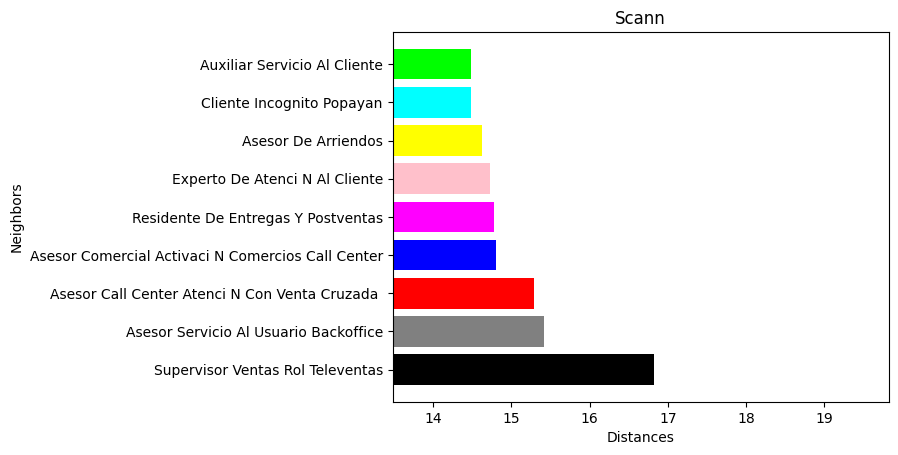

In [27]:
import matplotlib.pyplot as plt

colors = ['black', 'gray', 'red', 'blue', 'magenta', 'pink', 'yellow', 'cyan', 'green', 'lime']
plt.barh(list(df.iloc[neighbors[0],:].Vacancy_name),distances[0],color=colors)
plt.xlim(min(distances[0])-1, max(distances[0])+3)
plt.title("Scann")
plt.xlabel("Distances")
plt.ylabel("Neighbors")
plt.show()